## Set up libraries

In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm

import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)
#jax.config.update("jax_platform_name", "cpu")

jnp.array([0]) # So warnings don't show up later
jax.local_devices()

[GpuDevice(id=0, task=0)]

In [3]:
import sys
sys.path.append("../..")

from adversarial_ntks import attacks, jsvc, kernel

# Data generation

Our data in labeled by $Y \in \{0, 1\}$,
and $X | Y \sim \mathcal{N}(0, \sigma_Y \cdot I_d)$.

In [4]:
def generate_normal_data(dim, s0, s1, num_samples):
    assert num_samples % 2 == 0
    assert s0 <= s1
    
    ys = np.concatenate([
        np.zeros(shape=num_samples // 2, dtype=np.int64),
        np.ones(shape=num_samples // 2, dtype=np.int64)
    ])
    
    xs = np.concatenate([
        np.random.normal(scale=s0, size=(num_samples // 2, dim)),
        np.random.normal(scale=s1, size=(num_samples // 2, dim))
    ])
    
    perm = np.random.permutation(num_samples)
    xs = xs[perm]
    ys = ys[perm]
    
    return xs, ys

def normalize(xs: np.ndarray, norm):
    norm_xs = xs / np.linalg.norm(xs, axis=-1, ord=norm).reshape(-1, 1)
    return norm_xs

def radial_attack(
    xs: np.ndarray, ys: np.ndarray,
    attack_norm, attack_eps,
):
    norm_xs = normalize(xs, norm=attack_norm)
    
    adv_xs = xs.copy()
    adv_xs[ys == 0] += attack_eps * norm_xs[ys == 0]
    adv_xs[ys == 1] -= attack_eps * norm_xs[ys == 1]
    
    return adv_xs

xs, ys = generate_normal_data(dim=2, s0=0.3, s1=0.7, num_samples=4)
radial_attack(xs=xs, ys=ys, attack_norm=2, attack_eps=0.1)

array([[ 0.38744963, -0.20487095],
       [ 0.26601769,  0.28142588],
       [-0.27832792, -0.16037272],
       [ 0.68538163,  0.40481577]])

## Some utilities

In [5]:
def accs_by_cls(preds, ys):
    return (preds[ys == 0] == 0).mean(), (preds[ys == 1] == 1).mean()

def fmt_accs(accs):
    return "(" + ", ".join(f"{a:.4f}" for a in accs) + ")"

# Experiments

In [6]:
RESULTS = dict() # used to store experiment artifacts

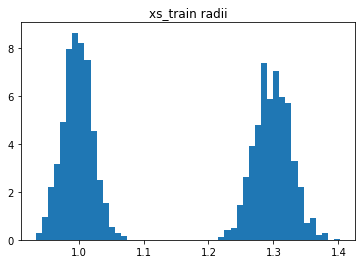

In [7]:
_DIM = 1000
_R0, _R1 = 1.0, 1.3
_S0, _S1 = _R0 / np.sqrt(_DIM), _R1 / np.sqrt(_DIM)

xs_train, ys_train = generate_normal_data(
    dim=_DIM, s0=_S0, s1=_S1, num_samples=2000,
)
xs_test, ys_test = generate_normal_data(
    dim=_DIM, s0=_S0, s1=_S1, num_samples=1000,
)

plt.title("xs_train radii")
plt.hist(np.linalg.norm(xs_train, ord=2, axis=-1), density=True, bins=50);

## Kernel SVM

See https://scikit-learn.org/stable/modules/svm.html#svc to check that the formulation below matches the sklearn specs.

Let $(x_1, y_1), \ldots, (x_n, y_n) \in \mathcal{X} \times \{\pm 1\}$ be training data.

A binary kernel classifier $F_{\alpha, b}: \mathcal{X} \to \{\pm 1\}$ parameterized by
$\alpha, b \in \mathbb{R}^n \times \mathbb{R}$
and with kernel $k: \mathcal{X} \times \mathcal{X} \to \mathbb{R}$ acts as

$$
F_{\alpha, b}(x) \triangleq
\mathrm{sgn} ( f_{\alpha, b}(x))
\triangleq \mathrm{sgn} \left( b + \sum_{i = 1}^n \alpha_i \, k(x_i, x) \right).
$$

For a SVM, $\alpha$ and $b$ are found via empirical risk minimization on the regularized hinge loss:

$$
\underset{\alpha, \,b \,\in\, \mathbb{R}^n \times \mathbb{R}}{\mathrm{argmin}} \quad
\sum_{i = 1}^n \max(0, 1 - y_i f_{\alpha, b}(x_i)) +
\frac{1}{2C} \sum_{i = 1}^n \sum_{j = 1}^n \alpha_i \, \alpha_j \, k(x_i, x_j)
$$

Here $C$ inversely controls the strength of regularization, i.e. large $C$ means no regularization.
However note that $C$ does not automatically scale with $n$.

Writing out the objective in matrix form yields

$$
\mathcal{L}(\alpha, b)
= \mathbf{1}_n^\top \max(0, 1 - Y \odot K \alpha) + \frac{1}{2C} \alpha^\top K \alpha,
$$

where $K \in \mathbb{R}^{n \times n}$ with $K_{ij} = k(x_i, x_j)$
and $Y \in \mathbb{R}^n$ with $Y_i = y_i$.

### Notes
For theoretical analysis, we could drop the bias term since we can incorporate it into the kernel.

In [8]:
def eval_svm_clf(
    clf: svm.SVC,
    attack_eps: float,
    pgd_step_size: float,
    pgd_num_steps: int,
    verbose: bool = True,
    label: str = "",
):
    if verbose:
        print(f"{label}; n_support={clf.n_support_}; b={clf.intercept_[0]:.3e}; gam={clf._gamma:.3e}; coef0={clf.coef0}")
    
    accs_train = accs_by_cls(preds=clf.predict(xs_train), ys=ys_train)
    accs_test = accs_by_cls(preds=clf.predict(xs_test), ys=ys_test)
    if verbose:
        print(f"{label}; accs_train={fmt_accs(accs_train)}; accs_test={fmt_accs(accs_test)}")
    
    xs_train_arad = radial_attack(xs=xs_train, ys=ys_train, attack_norm=2, attack_eps=attack_eps)
    xs_test_arad = radial_attack(xs=xs_test, ys=ys_test, attack_norm=2, attack_eps=attack_eps)
    accs_train_arad = accs_by_cls(preds=clf.predict(xs_train_arad), ys=ys_train)
    accs_test_arad = accs_by_cls(preds=clf.predict(xs_test_arad), ys=ys_test)
    if verbose:
        print(f"{label}; accs_train_arad={fmt_accs(accs_train_arad)}; accs_test_arad={fmt_accs(accs_test_arad)}")
    
    xs_train_pgd = attacks.pgd(
        X=jnp.array(xs_train), Y=jnp.array(ys_train),
        grad_func=lambda X: jsvc.grad_decision_function(clf, X),
        eps=attack_eps, eps_norm=2,
        step_size=pgd_step_size, step_norm=2,
        num_steps=pgd_num_steps,
        pixel_clip=False,
    )
    xs_test_pgd = attacks.pgd(
        X=jnp.array(xs_test), Y=jnp.array(ys_test),
        grad_func=lambda X: jsvc.grad_decision_function(clf, X),
        eps=attack_eps, eps_norm=2,
        step_size=pgd_step_size, step_norm=2,
        num_steps=pgd_num_steps,
        pixel_clip=False,
    )
    accs_train_pgd = accs_by_cls(preds=clf.predict(xs_train_pgd), ys=ys_train)
    accs_test_pgd = accs_by_cls(preds=clf.predict(xs_test_pgd), ys=ys_test)
    if verbose:
        print(f"{label}; accs_train_pgd={fmt_accs(accs_train_pgd)}; accs_test_pgd={fmt_accs(accs_test_pgd)}")

    return dict(
        accs_train=accs_train,
        accs_test=accs_test,
        attack_eps=attack_eps,
        accs_train_arad=accs_train_arad,
        accs_test_arad=accs_test_arad,
        accs_train_pgd=accs_train_pgd,
        accs_test_pgd=accs_test_pgd,
        xs_train_pgd=xs_train_pgd,
        xs_test_pgd=xs_test_pgd,
    )

### Poly, deg=2

In [9]:
%%time
RESULTS["svm-poly"] = []
for c in [1e-4, 1e-2, 1, 100]:
    clf = svm.SVC(kernel="poly", degree=2, coef0=1, C=c)
    clf.fit(xs_train, ys_train)

    res_dict = dict(clf=clf)
    res_dict.update(
        eval_svm_clf(
            clf=clf,
            label=f"C={c}",
            attack_eps=0.1,
            pgd_step_size=0.1/10,
            pgd_num_steps=20,
        )
    )

    RESULTS["svm-poly"].append(res_dict)

C=0.0001; n_support=[1000 1000]; b=-1.654e-04; gam=7.448e-01; coef0=1
C=0.0001; accs_train=(0.9090, 0.8350); accs_test=(0.7380, 0.3460)
C=0.0001; accs_train_arad=(0.9020, 0.8050); accs_test_arad=(0.7140, 0.3280)
C=0.0001; accs_train_pgd=(0.0330, 0.0690); accs_test_pgd=(0.0040, 0.0020)
C=0.01; n_support=[1000 1000]; b=-1.654e-02; gam=7.448e-01; coef0=1
C=0.01; accs_train=(0.9090, 0.8350); accs_test=(0.7380, 0.3460)
C=0.01; accs_train_arad=(0.9020, 0.8050); accs_test_arad=(0.7140, 0.3280)
C=0.01; accs_train_pgd=(0.0330, 0.0690); accs_test_pgd=(0.0040, 0.0020)
C=1; n_support=[888 980]; b=-6.223e-01; gam=7.448e-01; coef0=1
C=1; accs_train=(0.9990, 1.0000); accs_test=(0.8160, 0.3100)
C=1; accs_train_arad=(0.9990, 1.0000); accs_test_arad=(0.7660, 0.2720)
C=1; accs_train_pgd=(0.0190, 0.0010); accs_test_pgd=(0.0100, 0.0000)
C=100; n_support=[869 984]; b=-6.826e-01; gam=7.448e-01; coef0=1
C=100; accs_train=(1.0000, 1.0000); accs_test=(0.8560, 0.2740)
C=100; accs_train_arad=(1.0000, 1.0000); acc

### RBF

In [10]:
%%time
attack_eps = 0.1

RESULTS["svm-rbf"] = []
for c in [1e-4, 1e-2, 1, 1e2, 1e4]:
    clf = svm.SVC(kernel="rbf", C=c)
    clf.fit(xs_train, ys_train)
    
    res_dict = dict(clf=clf)
    res_dict.update(
        eval_svm_clf(
            clf=clf,
            label=f"C={c}",
            attack_eps=0.1,
            pgd_step_size=0.1/10,
            pgd_num_steps=20,
        )
    )

    RESULTS["svm-rbf"].append(res_dict)

C=0.0001; n_support=[1000 1000]; b=7.188e-03; gam=7.448e-01; coef0=0.0
C=0.0001; accs_train=(1.0000, 1.0000); accs_test=(1.0000, 1.0000)
C=0.0001; accs_train_arad=(0.9880, 0.9860); accs_test_arad=(0.9900, 0.9620)
C=0.0001; accs_train_pgd=(0.9880, 0.9860); accs_test_pgd=(0.9880, 0.9600)
C=0.01; n_support=[1000 1000]; b=7.188e-01; gam=7.448e-01; coef0=0.0
C=0.01; accs_train=(1.0000, 1.0000); accs_test=(1.0000, 1.0000)
C=0.01; accs_train_arad=(0.9880, 0.9860); accs_test_arad=(0.9900, 0.9620)
C=0.01; accs_train_pgd=(0.9880, 0.9860); accs_test_pgd=(0.9880, 0.9600)
C=1; n_support=[409 467]; b=4.073e+00; gam=7.448e-01; coef0=0.0
C=1; accs_train=(1.0000, 1.0000); accs_test=(1.0000, 1.0000)
C=1; accs_train_arad=(1.0000, 1.0000); accs_test_arad=(0.9740, 0.9700)
C=1; accs_train_pgd=(1.0000, 1.0000); accs_test_pgd=(0.9640, 0.9680)
C=100.0; n_support=[409 467]; b=4.073e+00; gam=7.448e-01; coef0=0.0
C=100.0; accs_train=(1.0000, 1.0000); accs_test=(1.0000, 1.0000)
C=100.0; accs_train_arad=(1.0000, 1.

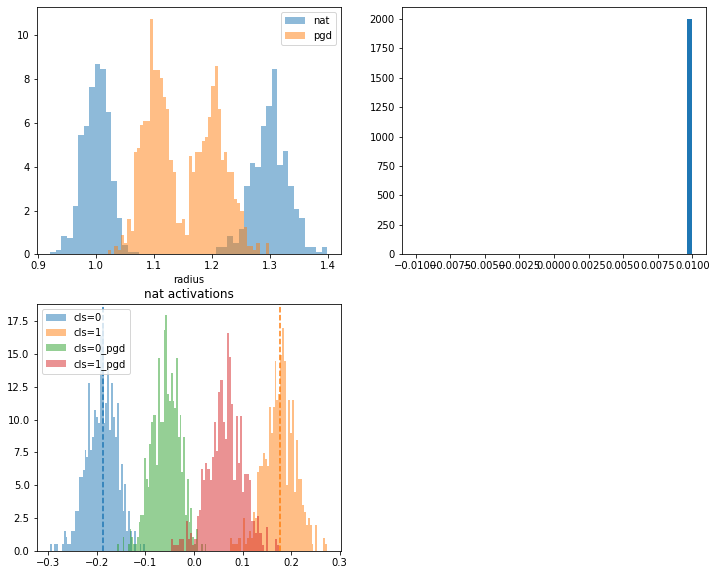

In [11]:
idx = 1
clf = RESULTS["svm-rbf"][idx]["clf"]
xs_test_pgd = RESULTS["svm-rbf"][idx]["xs_test_pgd"]

alphas = clf.dual_coef_.flatten() * (2 * ys_train - 1)[clf.support_.flatten()]

def rbf_small_c_act(clf: svm.SVC, r: float):
    num_samples, dim = xs_train.shape
    return (clf.C * num_samples  / 2) * (
        -np.exp(-clf._gamma * (_R0 ** 2 + r ** 2))
        + np.exp(-clf._gamma * (_R1 ** 2 + r ** 2))
    ) + clf.intercept_[0]


plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.hist(np.linalg.norm(xs_test, ord=2, axis=-1), density=True, bins=50, alpha=0.5, label="nat");
plt.hist(np.linalg.norm(xs_test_pgd, ord=2, axis=-1), density=True, bins=50, alpha=0.5, label="pgd");
plt.xlabel("radius");
plt.legend();

plt.subplot(2, 2, 2)
plt.hist(alphas, bins=50, range=[-clf.C, clf.C])

plt.subplot(2, 2, 3)
plt.title("nat activations")
plt.hist(
    clf.decision_function(xs_test[ys_test == 0]),
    density=True, bins=50, alpha=0.5, label="cls=0"
);
plt.hist(
    clf.decision_function(xs_test[ys_test == 1]),
    density=True, bins=50, alpha=0.5, label="cls=1"
);
plt.axvline(rbf_small_c_act(clf, r=1.0), color="C0", ls="--");
plt.axvline(rbf_small_c_act(clf, r=1.3), color="C1", ls="--");

plt.hist(
    clf.decision_function(xs_test_pgd[ys_test == 0]),
    density=True, bins=50, alpha=0.5, label="cls=0_pgd"
);
plt.hist(
    clf.decision_function(xs_test_pgd[ys_test == 1]),
    density=True, bins=50, alpha=0.5, label="cls=1_pgd"
);

plt.legend();

For the RBF kernel and small values of $C$ (i.e. strong regularization),
the SVM learns $\alpha^* = C \cdot 1_n$.

This in effect turns the classifier into a threshold classifier on vector norm, hence why it is so accurate and robust.